In [35]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

In [40]:
from my_commonfunctions import *
from scipy import ndimage

In [52]:
def add_padding(img_gray, ww, hh, color):
    ht, wd = img_gray.shape[:2]

    # create new image of desired size and color (blue) for padding
    result = np.full((hh, ww), color, dtype=np.uint8)

    # compute center offset
    xx = (ww - wd) // 2
    yy = (hh - ht) // 2

    # copy img image into center of result image
    result[yy:yy+ht, xx:xx+wd] = img_gray

    return result

In [64]:
imgs = []
names = []
for fn in os.listdir('Symbols'):
    if fn.endswith('.png'):
        image_path = 'Symbols/'+fn
        img = 255-my_imread_gray(image_path)
        img_padding = add_padding(img, ww=int(img.shape[1]*2.5), hh=int(img.shape[0]*1.5), color=0)
        # my_show_images([img, img_padding], dpi=100, row_max=2)
        imgs.append(img_padding)
        names.append(fn.split('.png')[0])

In [65]:
names

['sixtheenth_note',
 'eighth_note_upside_down',
 'sixtheenth_note_upside_down',
 'whole_note',
 'half_note',
 'thirty_second_note',
 'eighth_note',
 'natural_accidental',
 'time_signature_4_4',
 'treple_clef',
 'double_sharp_accidental',
 'thirty_second_note_upside_down',
 'time_signature_4_2',
 'quarter_note',
 'quarter_note_upside_down',
 'double_flat_accidental',
 'half_note_upside_down',
 'augmentation_dot',
 'flat_accidental',
 'sharp_accidental']

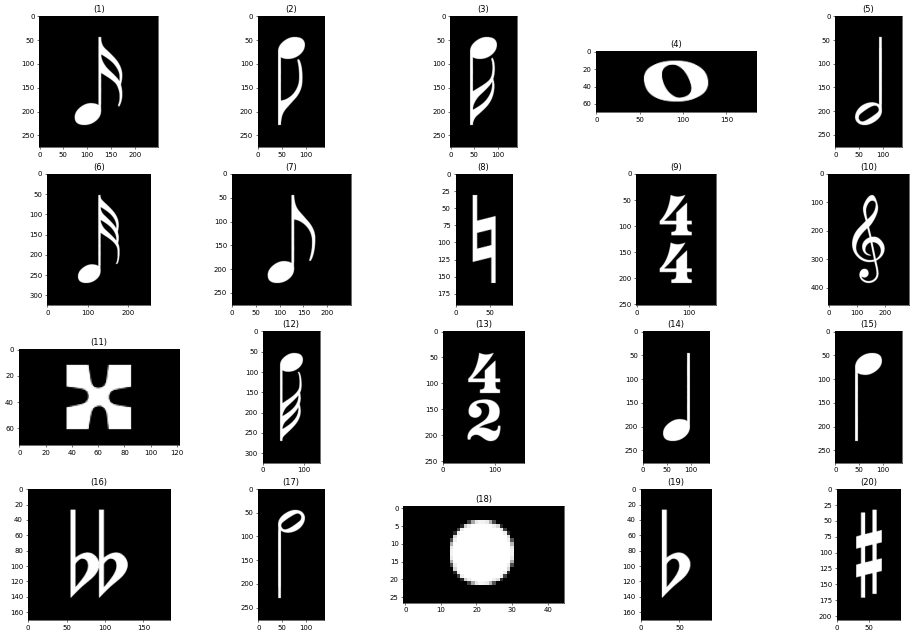

In [62]:
my_show_images(imgs, dpi=50, row_max=5)

In [66]:
for img, fn in zip(imgs, names):
	print('Augmenting \""' + fn + '\" .....')

	# convert to numpy array
	data = img_to_array(img)
	data = data.reshape((1, ) + data.shape)

	# expand dimension to one sample
	#samples = expand_dims(data, 0)
	# create image data augmentation generator
	datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.15, shear_range=0.2)
	'''# prepare iterator
	it = datagen.flow(samples, batch_size=1)
	# generate samples and plot
	for i in range(9):
		# define subplot
		pyplot.subplot(330 + 1 + i)
		# generate batch of images
		batch = it.next()
		# convert to unsigned integers for viewing
		image = batch[0].astype('uint8')
		# plot raw pixel data
		pyplot.imshow(image)'''

	for x, val in zip(datagen.flow(data,                    #image we chose
		save_to_dir='Symbols/data/'+fn,     #this is where we figure out where to save
		save_format='png'),range(400)) :     # here we define a range because we want 10 augmented images otherwise it will keep looping forever I think
		pass

	# show the figure
	# pyplot.show()

In [21]:
?ImageDataGenerator

Init signature:
ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format='channels_last',
    validation_split=0.0,
    interpolation_order=1,
    dtype='float32',
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.
 The data will be looped over (in batches).

# Arguments
    featurewise_center: Boolean.
        Set input mean to 0 over the dataset, feature-wise.
    samplewise_center: Boolean. Set each sample mean to 0.
    featurewise_std_normalization: Boolean.
        Di